In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

# Load shapefiles 

In [2]:
# kaweah shapefile
kaweah = gp.read_file("../shape/kb_rpj.shp")
k_area_km2 = float(kaweah.to_crs({'init': 'epsg:32611'}).area * 1e-6)
kaweah.crs = {"init":"epsg:4326"}

# flowlines
flowlines = gp.read_file("../shape/huc8_flow_line_Kaweah.shp")

# Rivers
rivers = gp.read_file("../shape/rivers.shp")

# Casgem wells within 
casgem = gp.read_file("../shape/wells.shp")

# Alpine watersheds 
sierra_sheds = gp.read_file("../shape/kaweah_watersheds.shp")

# Reservoirs
reservoirs = gp.read_file("../shape/reservoirs.shp")


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Load water balance data 

In [3]:
# Load preprocessed RS Data (P, R, SM, SWE) generated with 02_P_ET_SM
kawdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat.csv"))

# Inflow via streams, canals, aqueducts, etc 
q_in = rs.col_to_dt(pd.read_csv("../data/c2vsim_inflow_km3.csv"))

# Load ET data processed using crop coefficient method
modkc_et = rs.col_to_dt(pd.read_csv("../data/MODkc.csv"))
modkc_et.index = modkc_et.index + pd.offsets.MonthEnd(0) 

# Load SSEBop ET data
ssebop_et =  rs.col_to_dt(pd.read_csv("../data/ssebop_et.csv"))
ssebop_et.index = ssebop_et.index + pd.offsets.MonthEnd(0) 



In [4]:
# Merge dataframes
kdf1 = pd.merge(kawdf,q_in,left_index = True, right_index = True)
kdf2 = pd.merge(kdf1, modkc_et,left_index = True, right_index = True)
wbdf = pd.merge(kdf2, ssebop_et,left_index = True, right_index = True)

# Sum up the inflow
wbdf['inflow'] = wbdf[["Kaweah","Tule","Deer","White","FKC_tule",'FKC_kaweah']].sum(axis = 1)

# Load Validation data

In [5]:
# C2vsim 
c2vsim = pd.read_csv("../data/C2VSIM_sub18_GWS_km3.csv")
c2vsim['Date'] = pd.to_datetime(c2vsim['Date'])
c2vsim.index = c2vsim['Date']
c2vsim.drop('Date', axis = 1, inplace = True)

# Wells from Sarfaraz
# wells_ds = pd.read_csv("../data/wells.csv")
# wells_ds.index = pd.to_datetime(wells_ds['year'])
# wells_ds.index = wells_ds.index + pd.offsets.MonthEnd(0) 
# wells_ds.drop([wells_ds.columns[0],'year'], axis = 1, inplace = True)

wells_ds = pd.read_csv('../data/combine_sy_ss_estimates.csv')
wells_ds.index = pd.to_datetime(wells_ds['Year'])
wells_ds.index = wells_ds.index + pd.offsets.MonthEnd(0) 
wells_ds.drop([wells_ds.columns[0],'Year'], axis = 1, inplace = True)


In [7]:
####### TRIPLE COLLOCATION FUNCTIONS #######

def calc_tc_error(x,y,z):
    '''
    calculate errors between triplets
    '''
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    '''
    scale one dataset to another (mean / std)
    '''
    return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)


def do_tc(df):
    '''
    wrapper for calc_tc_error applied to a df 
    '''
    tc_dict = df.astype(float).to_dict('list')
    combos=itertools.permutations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

######## PLOTTING FUNCS #########
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    ydf.resample("Y").sum().boxplot(ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B') for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.style.use('default')
    plt.show()
    
def make_plots(df, coldict, var):
    '''
    for a dataframe of a single variable and a dict mapping col names to datasets, return:
    1) mean annual boxplot, 
    2) mean monthly scatterplot, 
    3) full timeseries, 
    4) correlation plot
    5) Triple collocation error box plot
    '''
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')

    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
        
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B')[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 3:4])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 4:5])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.tight_layout()
    plt.style.use('default')
    plt.show()

    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.38)
    # Time series
    ax5 = fig.add_subplot(gs[-1, :-1])
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.5),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)

    plt.tight_layout()

    plt.style.use('default')
    plt.show()

    
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)

    
def align_yaxis(axes):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array(axes)
    extrema = np.array([ax.get_ylim() for ax in axes])

    # reset for divide by zero issues
    for i in range(len(extrema)):
        if np.isclose(extrema[i, 0], 0.0):
            extrema[i, 0] = -1
        if np.isclose(extrema[i, 1], 0.0):
            extrema[i, 1] = 1

    # upper and lower limits
    lowers = extrema[:, 0]
    uppers = extrema[:, 1]

    # if all pos or all neg, don't scale
    all_positive = False
    all_negative = False
    if lowers.min() > 0.0:
        all_positive = True

    if uppers.max() < 0.0:
        all_negative = True

    if all_negative or all_positive:
        # don't scale
        return

    # pick "most centered" axis
    res = abs(uppers+lowers)
    min_index = np.argmin(res)

    # scale positive or negative part
    multiplier1 = abs(uppers[min_index]/lowers[min_index])
    multiplier2 = abs(lowers[min_index]/uppers[min_index])

    for i in range(len(extrema)):
        # scale positive or negative part based on which induces valid
        if i != min_index:
            lower_change = extrema[i, 1] * -1*multiplier2
            upper_change = extrema[i, 0] * -1*multiplier1
            if upper_change < extrema[i, 1]:
                extrema[i, 0] = lower_change
            else:
                extrema[i, 1] = upper_change

        # bump by 10% for a margin
        extrema[i, 0] *= 1.1
        extrema[i, 1] *= 1.1

    # set axes limits
    [axes[i].set_ylim(*extrema[i]) for i in range(len(extrema))]
    
    
########## TRENDLINE FUNCTIONS ###########
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cv_ds'][df_mask].values
    rscvws = df['cvws_ds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],1) for k,v in d.items()}
    
    return polyfits

def time_mask_df(df):
    mask = (df.index> "2001-09-30")
    return df.loc[mask]

# Study Area Map

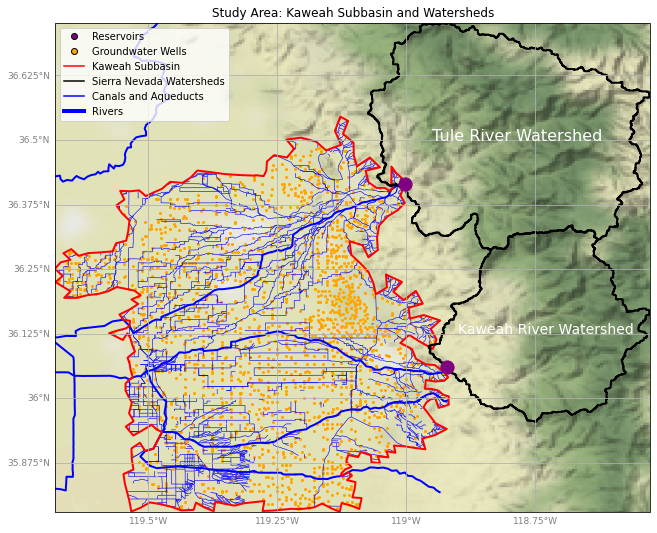

In [8]:
# Read datasets
flowlines = ShapelyFeature(Reader("../shape/huc8_flow_line_Kaweah.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 0.6)
kaweah = ShapelyFeature(Reader("../shape/kb_rpj.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='red', facecolor = 'none', linewidth = 2)
watersheds = ShapelyFeature(Reader("../shape/kaweah_watersheds.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)
streams = ShapelyFeature(Reader("../shape/rivers.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)


# Setup the figure
shapefile = "../shape/stud_area_dissolved.shp"
plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.right_labels = False

gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon, urlon, lllat, urlat])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add wells
wells = list(cartopy.io.shapereader.Reader("../shape/wells.shp").geometries())
ax.scatter([point.x for point in wells],
           [point.y for point in wells],
           transform=ccrs.PlateCarree(), color = 'orange', s = 4)

# Add shapefiles
ax.add_feature(flowlines)
ax.add_feature(streams)
ax.add_feature(kaweah)
ax.add_feature(watersheds)

# Add reservoirs
reservoirs = list(cartopy.io.shapereader.Reader("../shape/reservoirs.shp").geometries())
ax.scatter([point.x for point in reservoirs],
           [point.y for point in reservoirs],
           transform=ccrs.PlateCarree(), color = 'purple', s = 175, zorder = 1000)


# Setup legend
handles, labels = plt.gca().get_legend_handles_labels()

# Add legend entries
res_line = Line2D(range(0), range(0), label = 'Reservoirs', color="none", marker='o', markerfacecolor="purple")
well_line = Line2D(range(0), range(0), label = 'Groundwater Wells', color="none", marker='o', markerfacecolor="orange")
ksb_line = Line2D([0], [0], label='Kaweah Subbasin ', color='red')
shed_line = Line2D([0], [0], label='Sierra Nevada Watersheds', color='black')
canals_line = Line2D([0], [0], label='Canals and Aqueducts', color='blue')
rivers_line = Line2D([0], [0], label='Rivers', color='blue', linewidth = 4)


# Plot legend 
handles.extend([res_line, well_line, ksb_line,shed_line, canals_line, rivers_line])
plt.legend(handles=handles, loc = 'upper left')

# Annotations to label watersheds
# ax.annotate('peak', xy=(33.5, 2.5), xytext=(40, 4), fontsize=120,
#             arrowprops=dict(facecolor='black'))

ax.text(-118.95, 36.5, "Tule River Watershed", color = 'white', size = 16)
ax.text(-118.9, 36.125, "Kaweah River Watershed", color = 'white', size = 14)

# Set the title
ax.set_title("Study Area: Kaweah Subbasin and Watersheds", size = 12)

# Fix aspect
ax.set_aspect('auto')

plt.show()

# Comparison and error analysis

In [9]:
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (13,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.25)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60, fontsize = 14)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k], label = k)

    labels = [str(datetime.date(1900, x, 1).strftime('%B'))[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.legend(loc="upper right", ncol = 1,bbox_to_anchor=(1.45, 1.),
               fancybox=True,  prop={'size': 13})
    plt.style.use('default')
    plt.show()
    


In [10]:
def timeseries(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    fig = plt.figure(figsize = (12,4))
    
    # Boxplot
    ax5 = fig.add_subplot(111)
    
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.29),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)
    plt.show()
    

In [11]:
def corr_err(df,coldict,var):

    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (12,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.15)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 0:1])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 1:2])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.suptitle(var, size = 20)
    plt.tight_layout()
    plt.style.use('default')
    plt.show()
    

In [12]:
wbdf['inflow'] = wbdf[["Kaweah","Tule","Deer","White","FKC_tule",'FKC_kaweah']].sum(axis = 1)

In [13]:
startidx = 8

pcoldict = {'p_prism':'PRISM', 
                'p_gpm':'GPM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())][startidx:-5]
pdf.dropna(axis = 0, how = 'all', inplace = True)
pdf.rename(columns = pcoldict, inplace = True)
pdf = time_mask_df(pdf)

aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'MODkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())][startidx:-5]
aetdf.dropna(axis = 0, how = 'all', inplace = True)
aetdf.rename(columns = aetcoldict, inplace = True)
aetdf = time_mask_df(aetdf)

petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TerraClim',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())][startidx:-5]
petdf.dropna(axis = 0, how = 'all', inplace = True)
petdf.rename(columns = petcoldict, inplace = True)
petdf = time_mask_df(petdf)

smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TerraClim',
                'sm_gldas': "GLDAS"}
smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())][startidx:-5]
smdf.dropna(axis = 0, how = 'all', inplace = True)
smdf.rename(columns = smcoldict, inplace = True)
smdf = time_mask_df(smdf)

rcoldict = {'inflow': 'Inflow',
            'r_fldas':'FLDAS',  
            'r_tc':'TerraClim',
            'r_gldas': "GLDAS"}
rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())][startidx:-5]
rdf.dropna(axis = 0, how = 'all', inplace = True)
rdf.rename(columns = rcoldict, inplace = True)
rdf = time_mask_df(rdf)


<ipython-input-7-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


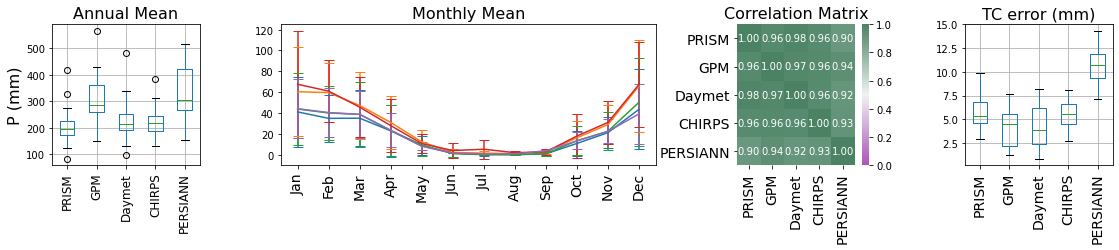

<ipython-input-7-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


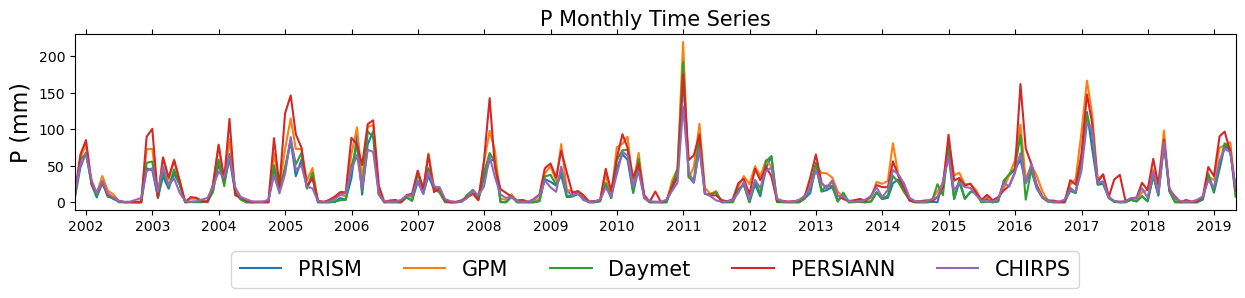

<ipython-input-7-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


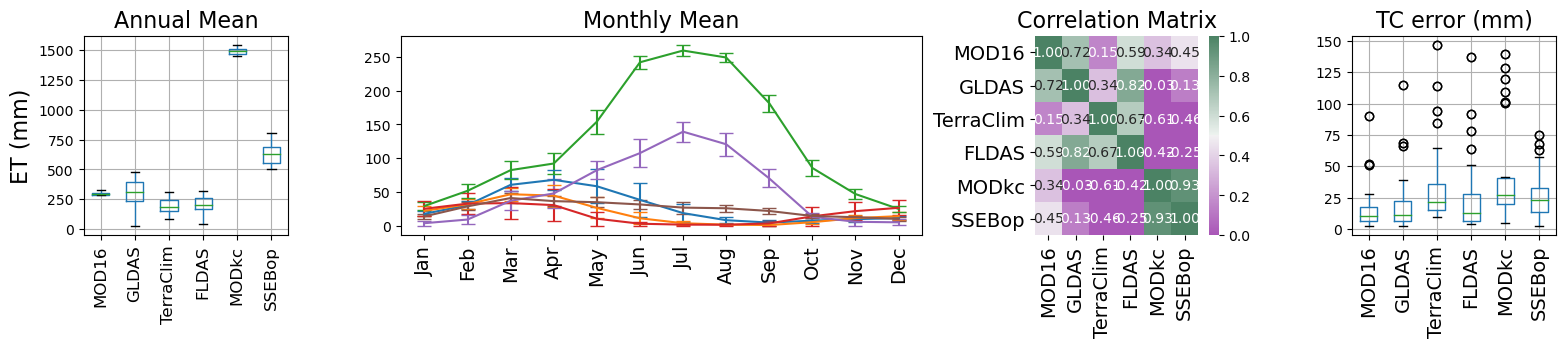

<ipython-input-7-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


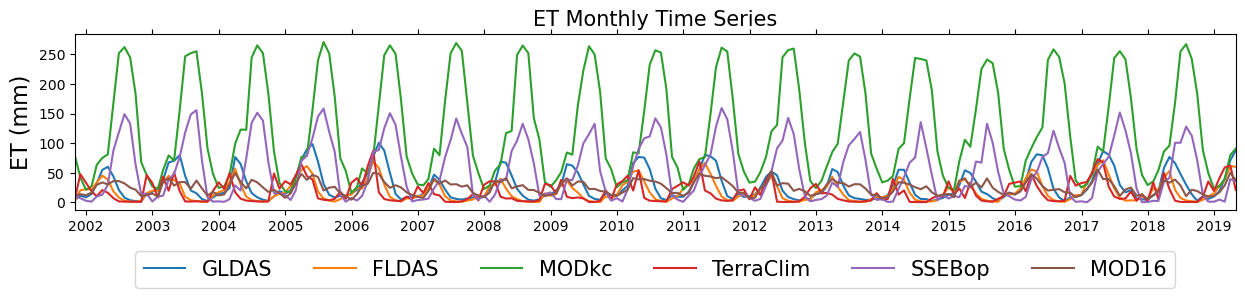

<ipython-input-7-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


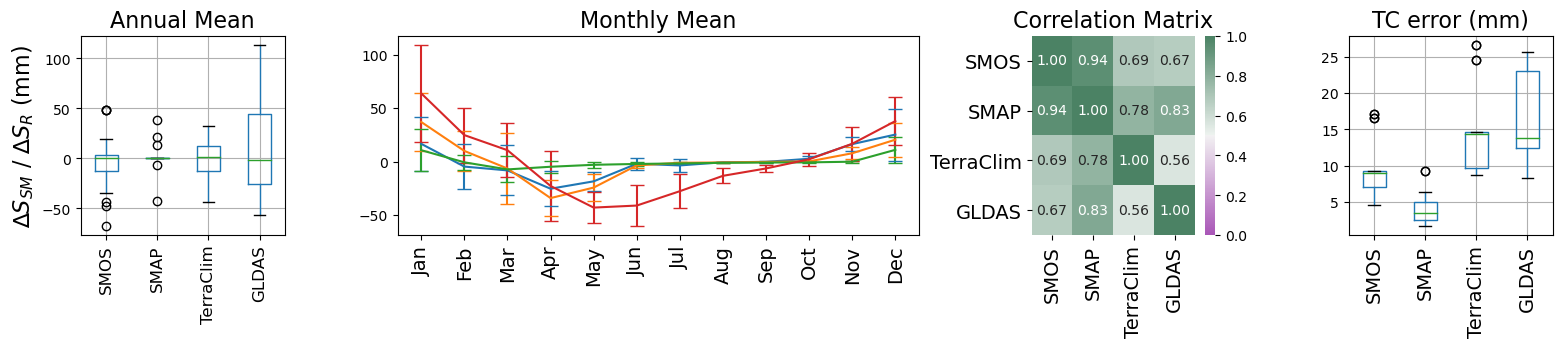

<ipython-input-7-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


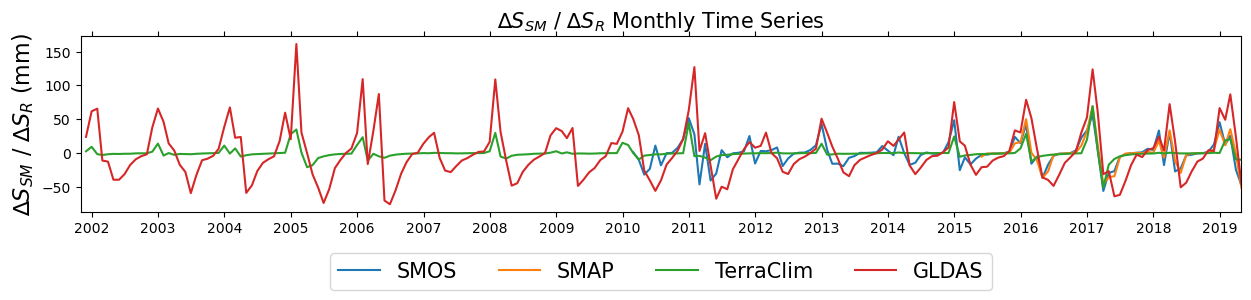

<ipython-input-7-691ac4ba90bf>:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


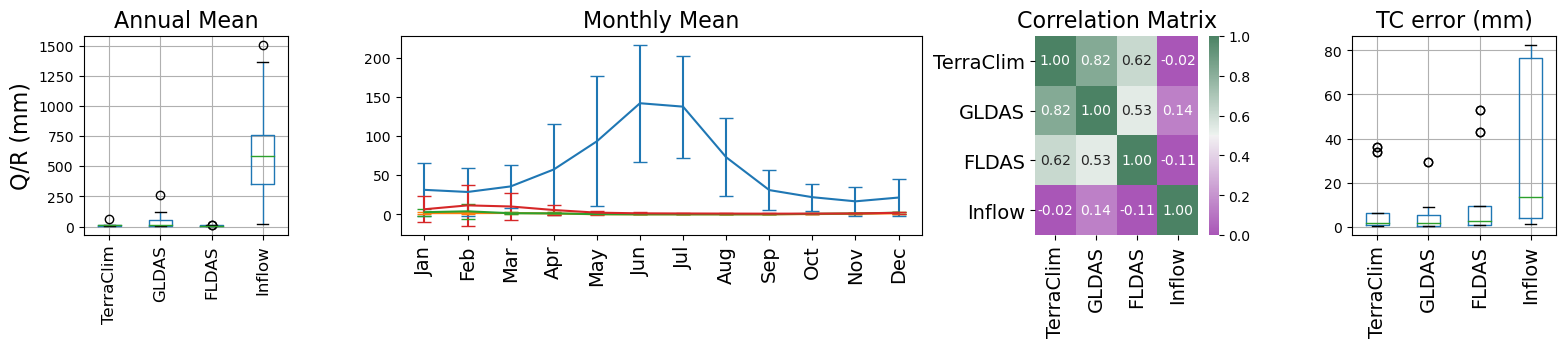

<ipython-input-7-691ac4ba90bf>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


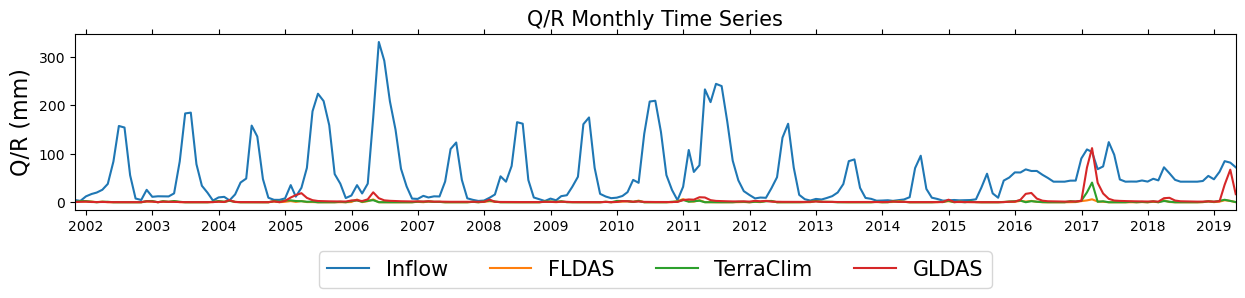

In [14]:
# plt.style.use("default")

make_plots(pdf/ k_area_km2 * 1e6, pcoldict, var = "P")
make_plots(aetdf/ k_area_km2 * 1e6, aetcoldict, var = "ET")
make_plots(smdf.diff() / k_area_km2 * 1e6, smcoldict, var = "∆$S_{SM}$ / ∆$S_{R}$")
make_plots(rdf/ k_area_km2 * 1e6, rcoldict, var = "Q/R")

# Ensemble Balance

In [15]:
# CV full ensemble list 
plist = ["PRISM", "Daymet",'GPM','CHIRPS', "PERSIANN"]
etlist = ['TerraClim', "FLDAS", 'GLDAS','SSEBop','MODkc',"MOD16"]
smlist = ['TerraClim', "GLDAS",'SMOS','SMAP']
rlist = ['GLDAS', 'FLDAS','TerraClim']

combolist = list(itertools.product(*[plist,etlist,smlist,rlist]))
print("Full Ensemble has {} members".format(str(len(combolist))))

# CV LSM ensemble list 
plist_lsm = [ "PRISM", "Daymet"]
etlist_lsm = [ 'TerraClim', "FLDAS", 'GLDAS']
smlist_lsm = ['TerraClim', "GLDAS"]
rlist_lsm = ['GLDAS', 'FLDAS','TerraClim']

combolist_lsm = list(itertools.product(*[plist_lsm,etlist_lsm,smlist_lsm,rlist_lsm]))
print("LSM-based Ensemble has {} members".format(str(len(combolist_lsm))))

# CV RS ensemble list 
plist_rs = ['GPM','CHIRPS', "PERSIANN"]
etlist_rs = ['SSEBop','MODkc',"MOD16"]
smlist_rs = ['SMOS','SMAP','TerraClim']
rlist_rs = ['GLDAS','FLDAS','TerraClim']

combolist_rs = list(itertools.product(*[plist_rs,etlist_rs,smlist_rs,rlist_rs]))
print("RS based Ensemble has {} members".format(str(len(combolist_rs))))

Full Ensemble has 360 members
LSM-based Ensemble has 36 members
RS based Ensemble has 81 members


In [16]:
startidx = 8

pcoldict = {'p_prism':'PRISM', 
                'p_gpm':'GPM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())][startidx:-5]
pdf.dropna(axis = 0, how = 'all', inplace = True)
pdf.rename(columns = pcoldict, inplace = True)
pdf = time_mask_df(pdf)

aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'MODkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())][startidx:-5]
aetdf.dropna(axis = 0, how = 'all', inplace = True)
aetdf.rename(columns = aetcoldict, inplace = True)
aetdf = time_mask_df(aetdf)

petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TerraClim',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())][startidx:-5]
petdf.dropna(axis = 0, how = 'all', inplace = True)
petdf.rename(columns = petcoldict, inplace = True)
petdf = time_mask_df(petdf)

smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TerraClim',
                'sm_gldas': "GLDAS",
                'Sres_cv':"Reservoirs"}
smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())][startidx:-5]
smdf.dropna(axis = 0, how = 'all', inplace = True)
smdf.rename(columns = smcoldict, inplace = True)
smdf = time_mask_df(smdf)

rcoldict = {'inflow': 'Inflow',
            'r_fldas':'FLDAS',  
            'r_tc':'TerraClim',
            'r_gldas': "GLDAS"}
rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())][startidx:-5]
rdf.dropna(axis = 0, how = 'all', inplace = True)
rdf.rename(columns = rcoldict, inplace = True)
rdf = time_mask_df(rdf)


In [17]:
# Run the ensembles
calibration_period = 60

dsens = []
for p,et,sm,r in combolist:
    ds = pdf[p] - aetdf[et] + rdf['Inflow'] - smdf[sm].diff() + rdf[r]
    dsens.append(np.cumsum(ds - np.mean(ds[:calibration_period])))

dsens_lsm = []
for p,et,sm,r in combolist_lsm:
    ds_lsm = pdf[p] - aetdf[et]  + rdf['Inflow'] - smdf[sm].diff() + rdf[r] 
    dsens_lsm.append(np.cumsum(ds_lsm - np.mean(ds_lsm[:calibration_period])))    

dsens_rs = []
for p,et,sm,r in combolist_rs:
    ds_rs = pdf[p] - aetdf[et] + rdf['Inflow'] - smdf[sm].diff() + rdf[r] 
    dsens_rs.append(np.cumsum(ds_rs - np.mean(ds_rs[:calibration_period])))
    
    
# Optimal ensemble - MODIS / ETkc mean, 
# Mean SNODAS / LRM swe
aetdf['rs_et_mean'] = np.nanmean([aetdf.loc[:,'MODkc'],aetdf.loc[:,'SSEBop']], axis = 0)
smdf['rs_sm_mean'] = np.nanmean([smdf.loc[:,'TerraClim'],smdf.loc[:,'SMOS'],smdf.loc[:,'SMAP']], axis = 0)
rdf['r_mean'] = np.nanmean([rdf.loc[:,'TerraClim'],rdf.loc[:,'FLDAS'],rdf.loc[:,'GLDAS']], axis = 0)

ds_opt_raw = pdf['GPM'] - aetdf['rs_et_mean'] + rdf['Inflow'] +rdf['r_mean'] - smdf['rs_sm_mean'].diff() 
ds_opt = np.cumsum(ds_opt_raw - np.mean(ds_opt_raw[:calibration_period]))

In [18]:
# Add the 8mo and 12mo moving averages 
# wells_ds['gws_km3_12'] = wells_ds['gws_km3'].rolling(12).mean()
# wells_ds['gws_km3_8'] = wells_ds['gws_km3'].rolling(8).mean()

In [19]:
# Take C2vsim relative to startdate of RS-based ensemble
c2vsim_subset = c2vsim.loc[wbdf.index[startidx]:,:]
offset = c2vsim.loc[wbdf.index[startidx]:,:].iloc[0].values
overlap = c2vsim_subset - offset

<ipython-input-20-922cfb51d2eb>:25: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )
<ipython-input-20-922cfb51d2eb>:29: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')
<ipython-input-20-922cfb51d2eb>:33: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')


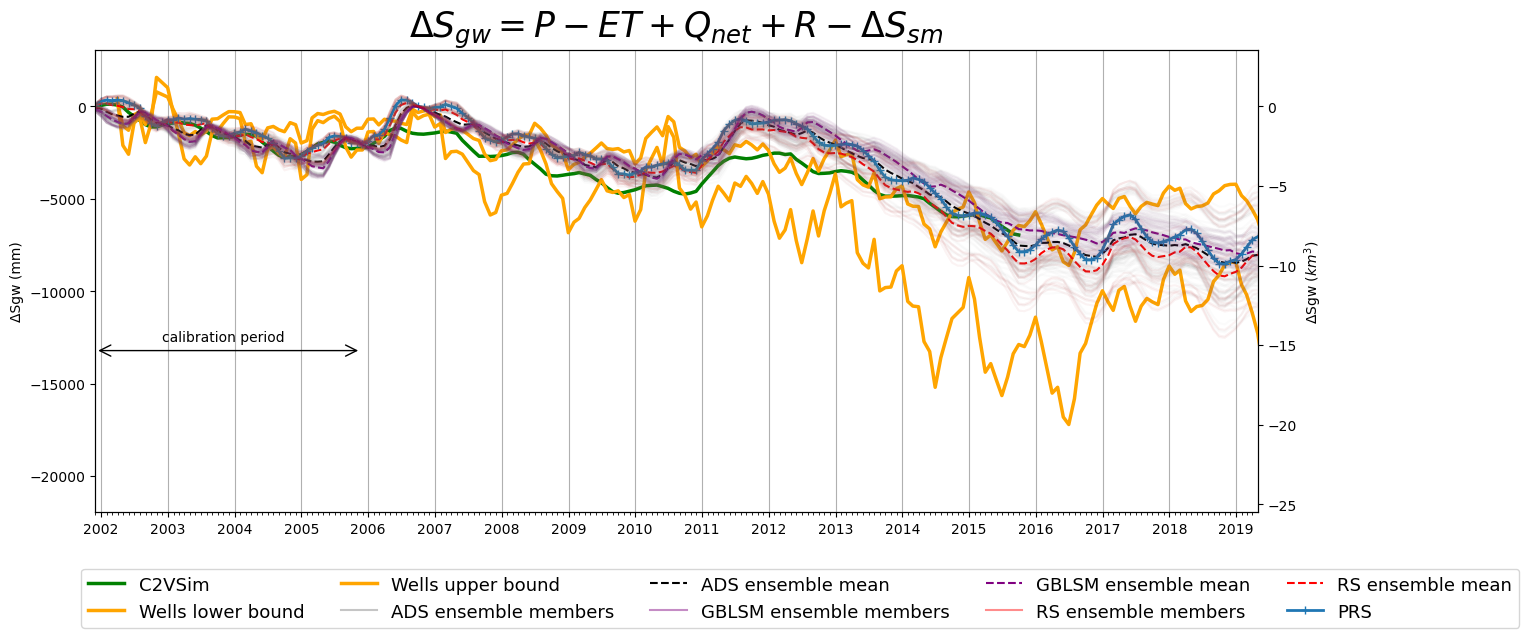

In [20]:
# Plot
plt.style.use('default')
fig, ax1 = plt.subplots(figsize = (15,6))

# Transparent dummy plot for the mm axis 
ax1.plot(c2vsim.index, c2vsim['Cum_end_stor_km3']/ k_area_km2 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 

ax1.set_ylabel('ΔSgw (mm)')

ax1.grid(axis = 'x')

# Second axis for Km^3
ax2 = ax1.twinx()  

# Plot c2vsim
ax2.plot(overlap.index, overlap['Cum_end_stor_km3'], color="green", linewidth = 2.5,label = "C2VSim") 

# plot wells
ax2.plot(wells_ds.index, wells_ds['Mean_of_sy_ss'], color="orange", linewidth = 2.5,label = "Wells lower bound")
ax2.plot(wells_ds.index, wells_ds['Sy_MA6'], color="orange", linewidth = 2.5,label = "Wells upper bound")


# Plot all
ax2.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensemble members')
ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )

# Plot LSM
ax2.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensemble members')
ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')

# Plot RS 
ax2.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'RS ensemble members')
ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')

# Plot optimal
ax2.plot(ds_opt, label = 'PRS', marker = "+",linewidth = 2)

# Formatting 
ax2.set_ylabel('ΔSgw ($km^3$)') # Label km3
align_yaxis([ax1,ax2]) # Align the twin axes

# plot all ensembles 
for d in dsens:
    ax2.plot(d, alpha = 0.03, color = 'gray')
    
# plot all LSM ensembles 
for d in dsens_lsm:
    ax2.plot(d, alpha = 0.03, color = 'purple')
    
# plot all RS ensembles 
for d in dsens_rs:
    ax2.plot(d, alpha = 0.03, color = 'red')

    
# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt.dropna())*0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax2.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax2.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax2.set_xlim(ds_opt.dropna().index[0], ds_opt.dropna().index[-1] )

# Title
ax2.set_title("$\Delta S_{gw} = P - ET + Q_{net} + R - \Delta S_{sm}$", size = 25)

# Align axes to 0
align_yaxis([ax1,ax2])

plt.legend(loc='lower left', ncol = 5, bbox_to_anchor=(-0.02, -0.27),
               fancybox=True,  prop={'size': 13})    


# Add shading and trendlines

In [21]:
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    all_ds = df['ds_km3'][df_mask].values
    lsm_ds = df['ds_lsm'][df_mask].values
    rs_ds = df['ds_rs'][df_mask].values
    rs_ds_opt = df['ds_rs_opt'][df_mask].values
    c2vsim = df['Cum_end_stor_km3'][df_mask].values
    wells = df['Mean_of_sy_ss'][df_mask].values
    
    dat = [all_ds, lsm_ds,rs_ds, rs_ds_opt, c2vsim, wells]
    
    dat_dict = dict(zip(['all_ds','LSM_ds', 'RS_ds','RS_ds_opt','C2VSim','wells'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],1) for k,v in d.items()}
    
    return polyfits

In [22]:
# Compile the ensemble results  

ds_df = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
ds_df.columns = ['ds_km3']
ds_df['ds_lsm'] = np.nanmean(np.vstack(dsens_lsm), axis = 0)
ds_df['ds_rs'] = np.nanmean(np.vstack(dsens_rs), axis = 0)
ds_df['ds_rs_opt'] = ds_opt


# Merge 
fin_dsdf_t1 = pd.merge(ds_df,overlap, left_index = True, right_index = True, how = 'outer')
fin_dsdf = pd.merge(fin_dsdf_t1,wells_ds.dropna(), left_index = True, right_index = True, how = 'outer').dropna()

<ipython-input-22-6b7bf9ccb0d7>:3: RuntimeWarning: Mean of empty slice
  ds_df = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
<ipython-input-22-6b7bf9ccb0d7>:5: RuntimeWarning: Mean of empty slice
  ds_df['ds_lsm'] = np.nanmean(np.vstack(dsens_lsm), axis = 0)
<ipython-input-22-6b7bf9ccb0d7>:6: RuntimeWarning: Mean of empty slice
  ds_df['ds_rs'] = np.nanmean(np.vstack(dsens_rs), axis = 0)


In [23]:
# Select droughts / floods
d1s,d1e = '2006-10-01', '2009-09-30'
d1t = get_trendlines(d1s,d1e,fin_dsdf)
d1s = get_slopes(d1s,d1e,fin_dsdf)

d2s,d2e = '2011-10-01', '2015-09-30'
d2t = get_trendlines(d2s,d2e,fin_dsdf)
d2s = get_slopes(d2s,d2e,fin_dsdf)

rc1s,rc1e = '2005-10-01', '2006-09-30'
rc1 = get_trendlines(rc1s,rc1e,fin_dsdf)
rc1s = get_slopes(rc1s,rc1e,fin_dsdf)

rc2s,rc2e = '2009-10-01', '2011-09-30'
rc2 = get_trendlines(rc2s,rc2e,fin_dsdf)
rc2s = get_slopes(rc2s,rc2e,fin_dsdf)

In [24]:
# Get the stats over wet/dry periods

ww1start = '2005-10-01'
ww1end = '2006-09-30'
print(ww1start)
w1d = filt_df_dates(fin_dsdf, ww1start, ww1end)
w1out = {k:fit_trend(v) for k,v in w1d.items()}
for k,v in w1out.items():
    print(k, v[1])


d1start = '2006-10-01'
d1end = '2009-09-30'
print(d1start)
d1d = filt_df_dates(fin_dsdf, d1start, d1end)
d1out = {k:fit_trend(v) for k,v in d1d.items()}
for k,v in d1out.items():
    print(k, v[1]*3)

ww2start = '2009-10-01'
ww2end = '2011-09-30'
print(ww2start)
w2d = filt_df_dates(fin_dsdf, ww2start, ww2end)
w2out= {k:fit_trend(v) for k,v in w2d.items()}
for k,v in w2out.items():
    print(k, v[1]*2)

d2start = '2011-10-01'
d2end = '2015-09-30'
print(d2start)
d2d = filt_df_dates(fin_dsdf, d2start, d2end)
d2out = {k:fit_trend(v) for k,v in d2d.items()}
for k,v in d2out.items():
    print(k, v[1]*4)

    
ww3start = '2016-10-01'
ww3end = '2017-09-30'
print(ww3start)
w3d = filt_df_dates(fin_dsdf, ww3start, ww3end)
w3out = {}
for k,v in w3d.items():
    try:
        w3out[k] = fit_trend(v)
    except:
        continue

for k,v in w3out.items():
    print(k, v[1])


2005-10-01
all_ds 1.4849982747977752
LSM_ds 1.4029456474346302
RS_ds 1.5797058978552512
RS_ds_opt 1.608359687508756
C2VSim 0.6266726274423067
wells 0.35574999999999996
2006-10-01
all_ds -5.459340496924936
LSM_ds -4.859335686629738
RS_ds -6.0854181232317295
RS_ds_opt -6.01386659631814
C2VSim -5.586388103858109
wells -3.07739864864865
2009-10-01
all_ds 3.25514956852685
LSM_ds 3.3747355877274856
RS_ds 3.2371788812939606
RS_ds_opt 3.6033822664435573
C2VSim 2.3769911986800047
wells -0.3024799999999992
2011-10-01
all_ds -15.72074832366579
LSM_ds -14.738528209852387
RS_ds -16.938393331554465
RS_ds_opt -16.245783872585847
C2VSim -10.377890166744894
wells -11.767653061224488
2016-10-01


<ipython-input-25-4d53fa6930ad>:23: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )
<ipython-input-25-4d53fa6930ad>:27: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')
<ipython-input-25-4d53fa6930ad>:31: RuntimeWarning: Mean of empty slice
  ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')


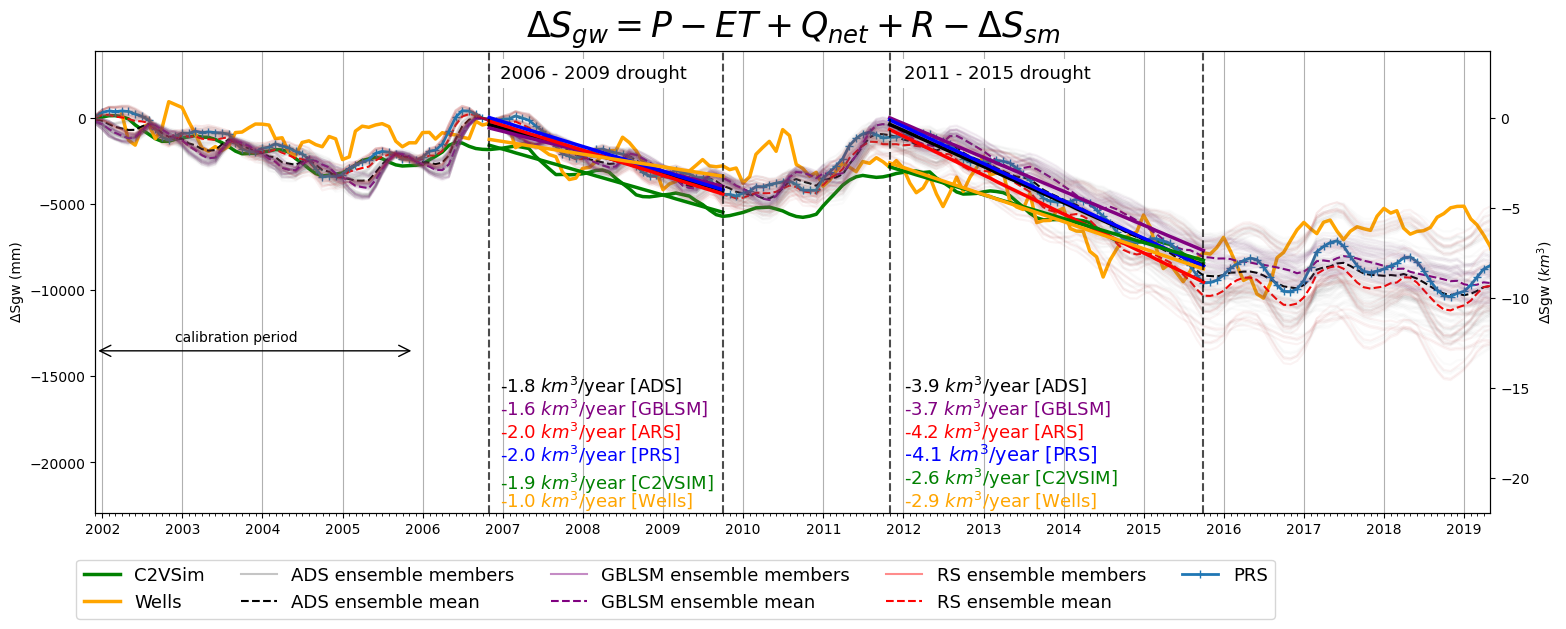

In [25]:
# Plot
plt.style.use('default')
fig, ax1 = plt.subplots(figsize = (18,6))

# Transparent dummy plot for the mm axis 
ax1.plot(c2vsim.index, c2vsim['Cum_end_stor_km3']/ k_area_km2 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 

ax1.set_ylabel('ΔSgw (mm)')

ax1.grid(axis = 'x')

# Second axis for Km^3
ax2 = ax1.twinx()  

# Plot c2vsim
ax2.plot(overlap.index, overlap['Cum_end_stor_km3'], color="green", linewidth = 2.5,label = "C2VSim") 

# Plot wells
ax2.plot(wells_ds.index, wells_ds['Mean_of_sy_ss'], color="orange", linewidth = 2.5,label = "Wells") 

# Plot all
ax2.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensemble members')
ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )

# Plot LSM
ax2.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensemble members')
ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')

# Plot RS 
ax2.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'RS ensemble members')
ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')

# Plot optimal
ax2.plot(ds_opt, label = 'PRS', marker = "+",linewidth = 2)

# Formatting 
ax2.set_ylabel('ΔSgw ($km^3$)') # Label km3
align_yaxis([ax1,ax2]) # Align the twin axes

# plot all ensembles 
for d in dsens:
    ax2.plot(d, alpha = 0.03, color = 'gray')
    
# plot all LSM ensembles 
for d in dsens_lsm:
    ax2.plot(d, alpha = 0.03, color = 'purple')
    
# plot all RS ensembles 
for d in dsens_rs:
    ax2.plot(d, alpha = 0.03, color = 'red')

    
# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt.dropna())*0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax2.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax2.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax2.set_xlim(ds_opt.dropna().index[0], ds_opt.dropna().index[-1] )
ax2.set_ylim(np.nanmin(ds_opt.dropna())-10, np.nanmax(ds_opt.dropna())+3)


# Title
ax2.set_title("$\Delta S_{gw} = P - ET + Q_{net} + R - \Delta S_{sm}$", size = 25)

# Align axes
align_yaxis([ax1,ax2])

# add legend
plt.legend(loc='lower left', ncol = 5, bbox_to_anchor=(-0.02, -0.25),
               fancybox=True,  prop={'size': 13})    
    

# Plot trendlines
ax2.plot(d1t['all_ds'], color = 'black', linewidth = 2.5) # trendline 
ax2.plot(d2t['all_ds'], color = 'black', linewidth = 2.5) # trendline 

ax2.plot(d1t['LSM_ds'], color = 'purple', linewidth = 2.5) # trendline 
ax2.plot(d2t['LSM_ds'], color = 'purple', linewidth = 2.5) # trendline 

ax2.plot(d1t['RS_ds'], color = 'red', linewidth = 2.5) # trendline 
ax2.plot(d2t['RS_ds'], color = 'red', linewidth = 2.5) # trendline 

ax2.plot(d1t['RS_ds_opt'], color = 'blue', linewidth = 2.5) # trendline 
ax2.plot(d2t['RS_ds_opt'], color = 'blue', linewidth = 2.5) # trendline 

ax2.plot(d1t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 
ax2.plot(d2t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 

ax2.plot(d1t['wells'], color = 'orange', linewidth = 2.5) # trendline 
ax2.plot(d2t['wells'], color = 'orange', linewidth = 2.5) # trendline 


# Shade droughts 
ax2.axvline(d1t['RS_ds'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax2.axvline(d1t['RS_ds'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

ax2.axvline(d2t['RS_ds'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax2.axvline(d2t['RS_ds'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

# Annotate slope of trendlines 
# Drought 1
ax2.annotate("2006 - 2009 drought", xy=(0.29, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13, bbox=dict(fc="white",lw = 0, ec = None))

ax2.annotate("{} $km^3$/year [ADS]".format(d1s['all_ds']),xy=(0.29, 0.26),
             color = "black", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [GBLSM]".format(d1s['LSM_ds']),xy=(0.29, 0.21),
             color = "purple", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [ARS]".format(d1s['RS_ds']),xy=(0.29, 0.16),
             color = "red", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [PRS]".format(d1s['RS_ds_opt']),xy=(0.29, 0.11),
             color = "blue", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [C2VSIM]".format(d1s['C2VSim']),xy=(0.29, 0.05), 
             color = 'green',xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [Wells]".format(d1s['wells']),xy=(0.29, 0.01), 
             color = 'orange',xycoords="axes fraction", size = 13)

# Drought 2
ax2.annotate("2011 - 2015 drought", xy=(0.58, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13,  bbox=dict(fc="white",lw = 0, ec = None))

ax2.annotate("{} $km^3$/year [ADS]".format(d2s['all_ds']),xy=(0.58, 0.26),
             color = "black", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [GBLSM]".format(d2s['LSM_ds']),xy=(0.58, 0.21),
             color = "purple", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [ARS]".format(d2s['RS_ds']),xy=(0.58, 0.16),
             color = "red", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [PRS]".format(d2s['RS_ds_opt']),xy=(0.58, 0.11),
             color = "blue", xycoords="axes fraction", size = 14)
ax2.annotate("{} $km^3$/year [C2VSIM]".format(d2s['C2VSim']),xy=(0.58, 0.06), 
             color = 'green',xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [Wells]".format(d2s['wells']),xy=(0.58, 0.01), 
             color = 'orange',xycoords="axes fraction", size = 13)

plt.show()
